In [2]:
# # Module 3 — Project 4
# ## Portfolio Risk & Diversification
#
# **Author:** Rein | Pixel Sky Solutions  
# **Course:** Python–Finance Master Plan
#
# ### Overview
# This notebook explores how asset correlation and weights affect portfolio risk.
# We will:
# 1. Generate synthetic returns for multiple assets.
# 2. Compute covariance & correlation matrices.
# 3. Calculate portfolio expected return and volatility for given weights.
# 4. Visualize the *risk-return* space using random portfolios (approximate efficient frontier).
# 5. Demonstrate diversification effects by changing correlations.
#
# This is a core skill for portfolio construction and risk management.

In [3]:
# ## Setup: imports, plotting style, reproducibility

In [47]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (10, 6)

RNG = 2025
np.random.seed(RNG)

In [9]:
# Ensure output folders exist
out_dir = "PHASE1/MODULE-3/charts"
os.makedirs(out_dir, exist_ok=True)

In [11]:
# ## Step 1 — Generate synthetic asset returns
#
# We'll simulate daily returns for 4 assets over ~3 years (3 * 252 trading days).
# We set target annual expected returns and volatilities, then construct a covariance
# matrix using a correlation matrix. Finally we draw multivariate normal returns.

In [12]:
n_days = 3 * 252
assets = ["Equity_US", "Equity_EM", "Bond_US", "Commodity"]

In [13]:
# Annual target returns (example)
mu_annual = np.array([0.10, 0.12, 0.03, 0.08])
mu_daily = mu_annual / 252.0

In [14]:
# Annual volatilities (example)
vol_annual = np.array([0.22, 0.30, 0.08, 0.35])
vol_daily = vol_annual / np.sqrt(252.0)

In [15]:
# Correlation matrix (base case)
corr_base = np.array([
    [1.0, 0.6, -0.2, 0.3],
    [0.6, 1.0, -0.1, 0.4],
    [-0.2, -0.1, 1.0, -0.05],
    [0.3, 0.4, -0.05, 1.0]
])

In [16]:
# Covariance matrix (daily)
D = np.diag(vol_daily)
cov_daily = D.dot(corr_base).dot(D)

In [17]:
print("Assets:", assets)
print("Mu (daily):", np.round(mu_daily, 6))
print("Vol (daily):", np.round(vol_daily, 6))
print("Cov (daily) shape:", cov_daily.shape)

Assets: ['Equity_US', 'Equity_EM', 'Bond_US', 'Commodity']
Mu (daily): [0.000397 0.000476 0.000119 0.000317]
Vol (daily): [0.013859 0.018898 0.00504  0.022048]
Cov (daily) shape: (4, 4)


In [18]:
# Draw multivariate normal daily returns

In [20]:
returns = np.random.multivariate_normal(mean=mu_daily, cov=cov_daily, size=n_days)
dates = pd.bdate_range(end=pd.Timestamp.today(), periods=n_days)
ret_df = pd.DataFrame(returns, columns=assets, index=dates)

In [21]:
# quick head
ret_df.head()

,Equity_US,Equity_EM,Bond_US,Commodity
2022-11-11,0.001443,0.009414,-0.001038,0.008157
2022-11-14,0.011545,0.019374,0.006354,0.000797
2022-11-15,0.011722,0.007137,0.002631,-0.004808
2022-11-16,-0.008880,0.003460,0.001569,-0.041284
2022-11-17,0.009230,0.005446,0.008922,-0.012018


In [22]:
# ## Step 2 — Descriptive stats: mean, vol, correlation
#
# Compute sample mean returns, annualized volatilities, covariance and correlation.

In [23]:
TRADING_DAYS = 252

In [24]:
# Sample stats
sample_mean_daily = ret_df.mean()
sample_std_daily = ret_df.std(ddof=1)

stats = pd.DataFrame({
    "mean_daily": sample_mean_daily,
    "std_daily": sample_std_daily,
    "mean_annual": sample_mean_daily * TRADING_DAYS,
    "std_annual": sample_std_daily * np.sqrt(TRADING_DAYS)
}).round(6)

In [25]:
print("Asset statistics (annualized where applicable):")
stats

Asset statistics (annualized where applicable):


,mean_daily,std_daily,mean_annual,std_annual
Equity_US,-0.000747,0.013801,-0.188304,0.219080
Equity_EM,-0.000631,0.019643,-0.158889,0.311829
Bond_US,0.000185,0.005357,0.046672,0.085037
Commodity,-0.000031,0.022635,-0.007734,0.359314


In [26]:
# Covariance & correlation (daily)
cov_empirical = ret_df.cov()
corr_empirical = ret_df.corr()

In [28]:
# Save to disk for reference
cov_empirical.to_csv("PHASE1/MODULE-3/cov_empirical.csv")
corr_empirical.to_csv("PHASE1/MODULE-3/corr_empirical.csv")

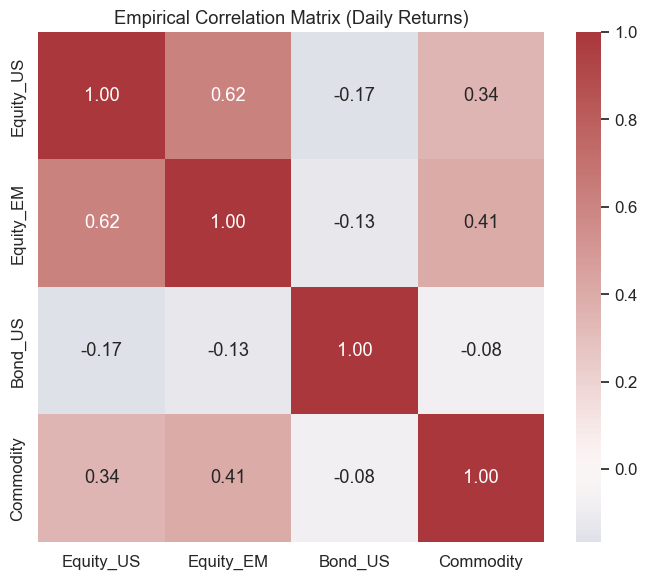

In [29]:
# Visualize correlation matrix
plt.figure(figsize=(7,6))
sns.heatmap(corr_empirical, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Empirical Correlation Matrix (Daily Returns)")
plt.tight_layout()
plt.savefig(f"{out_dir}/corr_matrix.png", dpi=150, bbox_inches="tight")
plt.show()

In [30]:
# ## Step 3 — Portfolio return & volatility functions
#
# Define reusable functions:
# - portfolio_return(weights, mean_vec)
# - portfolio_volatility(weights, cov_mat)
#
# Note: weights should sum to 1 (we will normalize if needed).

In [31]:
def portfolio_return(weights, mean_daily):
    """Expected portfolio daily return"""
    w = np.asarray(weights)
    return w.dot(mean_daily)

def portfolio_volatility(weights, cov_daily):
    """Portfolio daily volatility (std)"""
    w = np.asarray(weights)
    var_daily = w.T.dot(cov_daily).dot(w)
    return np.sqrt(var_daily)

In [32]:
# Quick test: equal weight portfolio
w_test = np.repeat(1/len(assets), len(assets))
print("Equal-weight expected daily return:", portfolio_return(w_test, sample_mean_daily))
print("Equal-weight daily vol:", portfolio_volatility(w_test, cov_empirical))

Equal-weight expected daily return: -0.00030580796803306653
Equal-weight daily vol: 0.011059557636899283


In [33]:
# ## Step 4 — Simulate many random portfolios (approximate efficient frontier)
#
# Generate many random weight vectors, compute annualized return and volatility,
# then plot the risk-return scatter. Highlight the min-vol portfolio and the max-Sharpe (with RF) portfolio.

In [35]:
# Random portfolios
n_portfolios = 6000
results = np.zeros((n_portfolios, 4))  # columns: ret, vol, sharpe, weights_idx (store later)
weights_store = []

rf_annual = 0.015
rf_daily = (1 + rf_annual) ** (1/TRADING_DAYS) - 1
rf_annual = rf_annual  # keep for sharpe annualized

for i in range(n_portfolios):
    # random weights via Dirichlet for positivity and sum=1
    w = np.random.dirichlet(np.ones(len(assets)), size=1).flatten()
    weights_store.append(w)
    port_mean_daily = portfolio_return(w, sample_mean_daily)
    port_vol_daily = portfolio_volatility(w, cov_empirical)
    # annualize
    port_mean_ann = port_mean_daily * TRADING_DAYS
    port_vol_ann = port_vol_daily * np.sqrt(TRADING_DAYS)
    sharpe_ann = (port_mean_ann - rf_annual) / port_vol_ann if port_vol_ann != 0 else 0.0
    results[i, 0] = port_mean_ann
    results[i, 1] = port_vol_ann
    results[i, 2] = sharpe_ann

results_df = pd.DataFrame(results[:, :3], columns=["ret_ann", "vol_ann", "sharpe"])

In [36]:
# Find min-vol and max-sharpe portfolios
idx_min_vol = results_df["vol_ann"].idxmin()
idx_max_sharpe = results_df["sharpe"].idxmax()
w_min_vol = weights_store[idx_min_vol]
w_max_sharpe = weights_store[idx_max_sharpe]

print("Min vol weights:", dict(zip(assets, np.round(w_min_vol,3))))
print("Max Sharpe weights:", dict(zip(assets, np.round(w_max_sharpe,3))))

Min vol weights: {'Equity_US': np.float64(0.132), 'Equity_EM': np.float64(0.006), 'Bond_US': np.float64(0.828), 'Commodity': np.float64(0.034)}
Max Sharpe weights: {'Equity_US': np.float64(0.014), 'Equity_EM': np.float64(0.018), 'Bond_US': np.float64(0.943), 'Commodity': np.float64(0.025)}


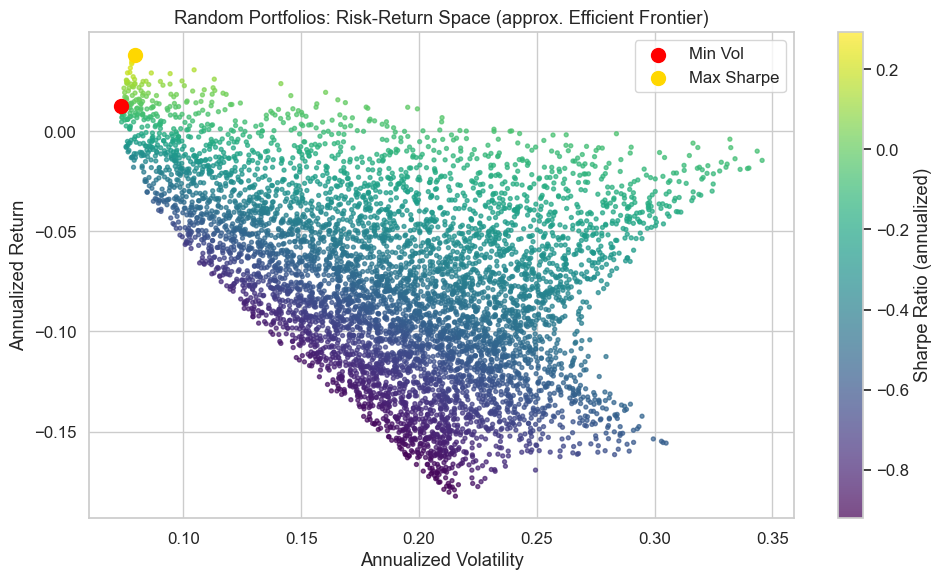

In [37]:
# Plot risk-return scatter
plt.figure(figsize=(10,6))
plt.scatter(results_df["vol_ann"], results_df["ret_ann"], c=results_df["sharpe"], cmap="viridis", s=8, alpha=0.7)
plt.colorbar(label="Sharpe Ratio (annualized)")
plt.scatter(results_df.loc[idx_min_vol,"vol_ann"], results_df.loc[idx_min_vol,"ret_ann"], c="red", s=100, label="Min Vol")
plt.scatter(results_df.loc[idx_max_sharpe,"vol_ann"], results_df.loc[idx_max_sharpe,"ret_ann"], c="gold", s=100, label="Max Sharpe")
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("Random Portfolios: Risk-Return Space (approx. Efficient Frontier)")
plt.legend()
plt.tight_layout()
plt.savefig(f"{out_dir}/risk_return_scatter.png", dpi=150, bbox_inches="tight")
plt.show()

In [38]:
# ## Step 5 — Show weights & performance for highlighted portfolios
#
# Display the metrics and weights for the min-vol and max-Sharpe portfolios.

In [39]:
def summarize_portfolio(w):
    ret_ann = portfolio_return(w, sample_mean_daily) * TRADING_DAYS
    vol_ann = portfolio_volatility(w, cov_empirical) * np.sqrt(TRADING_DAYS)
    sharpe = (ret_ann - rf_annual) / vol_ann if vol_ann != 0 else np.nan
    return {"weights": np.round(w,4), "ret_ann": ret_ann, "vol_ann": vol_ann, "sharpe": sharpe}

min_vol_summary = summarize_portfolio(w_min_vol)
max_sharpe_summary = summarize_portfolio(w_max_sharpe)

print("Min-vol portfolio summary:")
print(min_vol_summary)
print("\nMax-Sharpe portfolio summary:")
print(max_sharpe_summary)

Min-vol portfolio summary:
{'weights': array([0.132 , 0.006 , 0.8282, 0.0338]), 'ret_ann': np.float64(0.012592780467027458), 'vol_ann': np.float64(0.07366557168333167), 'sharpe': np.float64(-0.032677673952230035)}

Max-Sharpe portfolio summary:
{'weights': array([0.0143, 0.0179, 0.943 , 0.0247]), 'ret_ann': np.float64(0.0382755805251624), 'vol_ann': np.float64(0.07948710487418185), 'sharpe': np.float64(0.292822094376248)}


In [40]:
# ## Step 6 — Diversification effect: show portfolio vol as 
# correlation between two assets varies
#
# We'll vary correlation between Asset A and Asset B and compute portfolio 
# volatility for a 50/50 portfolio on those two assets
# while keeping other assets fixed (or excluded). This demonstrates how 
# lowering correlation reduces portfolio volatility.

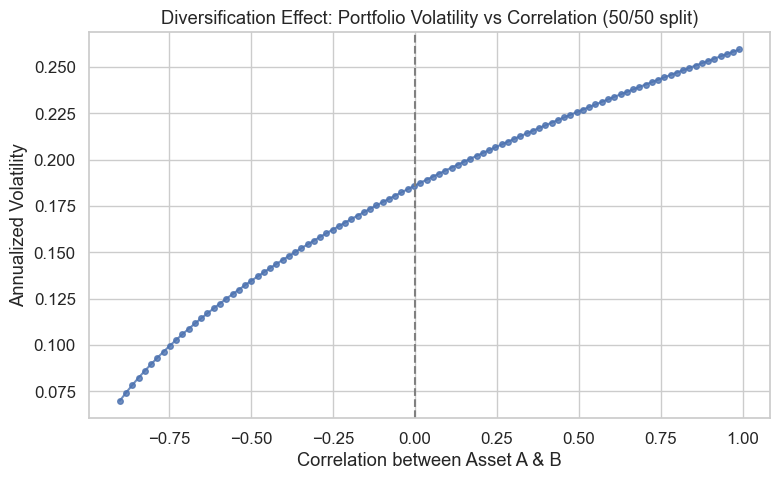

In [41]:
# Consider only assets 0 and 1 (Equity_US and Equity_EM)
a_idx, b_idx = 0, 1
w_pair = np.array([0.5, 0.5])

# Vary correlation from -0.9 to 0.99
corrs = np.linspace(-0.9, 0.99, 100)
vols_pair = []
for r in corrs:
    cov_pair = np.array([[vol_daily[a_idx]**2, r*vol_daily[a_idx]*vol_daily[b_idx]],
                         [r*vol_daily[a_idx]*vol_daily[b_idx], vol_daily[b_idx]**2]])
    vol_pair = np.sqrt(w_pair.T.dot(cov_pair).dot(w_pair)) * np.sqrt(TRADING_DAYS)  # annualized
    vols_pair.append(vol_pair)

plt.figure(figsize=(8,5))
plt.plot(corrs, vols_pair, marker="o", markersize=4, linestyle='-', alpha=0.8)
plt.axvline(0, color='grey', linestyle='--', label='Zero correlation')
plt.title("Diversification Effect: Portfolio Volatility vs Correlation (50/50 split)")
plt.xlabel("Correlation between Asset A & B")
plt.ylabel("Annualized Volatility")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{out_dir}/diversification_vs_correlation.png", dpi=150, bbox_inches="tight")
plt.show()

In [42]:
# ## Step 7 — Sensitivity: show how adding an uncorrelated asset 
# reduces portfolio risk
#
# Build 2-asset equal-weight portfolio and then add a third asset with 
# low correlation; compare volatilities.

In [43]:
# 2-asset equal-weight (Asset A & B)
w2 = np.array([0.5, 0.5, 0.0, 0.0])
vol2 = portfolio_volatility(w2, cov_empirical) * np.sqrt(TRADING_DAYS)

# 3-asset equal-weight (A, B, Bond_US)
w3 = np.array([1/3, 1/3, 1/3, 0.0])
vol3 = portfolio_volatility(w3, cov_empirical) * np.sqrt(TRADING_DAYS)

# 4-asset equal-weight (all)
w4 = np.array([0.25, 0.25, 0.25, 0.25])
vol4 = portfolio_volatility(w4, cov_empirical) * np.sqrt(TRADING_DAYS)

print("Annualized vol (2-asset 50/50):", vol2)
print("Annualized vol (3-asset equal):", vol3)
print("Annualized vol (4-asset equal):", vol4)

Annualized vol (2-asset 50/50): 0.23956085388805545
Annualized vol (3-asset equal): 0.15770796903021683
Annualized vol (4-asset equal): 0.1755650347057241


In [45]:
# ## Step 8 — Save artifact & short summary

In [49]:
def to_serializable(obj):
    """Convert NumPy types to Python native types for JSON serialization."""
    if isinstance(obj, (np.ndarray, list)):
        return [to_serializable(x) for x in obj]
    elif isinstance(obj, (np.float32, np.float64, np.int32, np.int64)):
        return float(obj)
    elif isinstance(obj, dict):
        return {k: to_serializable(v) for k, v in obj.items()}
    else:
        return obj

summary = {
    "min_vol_weights": to_serializable(w_min_vol),
    "max_sharpe_weights": to_serializable(w_max_sharpe),
    "min_vol_metrics": to_serializable(min_vol_summary),
    "max_sharpe_metrics": to_serializable(max_sharpe_summary),
    "vol_2asset_50_50": float(vol2),
    "vol_3asset_eq": float(vol3),
    "vol_4asset_eq": float(vol4)
}

with open("PHASE1/MODULE-3/summary_portfolio_risk.json", "w") as f:
    json.dump(summary, f, indent=2)